In [14]:
pip install sklearn_extra

<class 'OSError'>: Not available

Data loading and scaling complete.

Running K-Means...
K-Means Silhouette Score: 0.2849
K-Means Adjusted Rand Index (ARI): 0.8975

Running K-Medoids (custom implementation)...
K-Medoids Silhouette Score: 0.1548
K-Medoids Adjusted Rand Index (ARI): 0.3413

Generating plots...


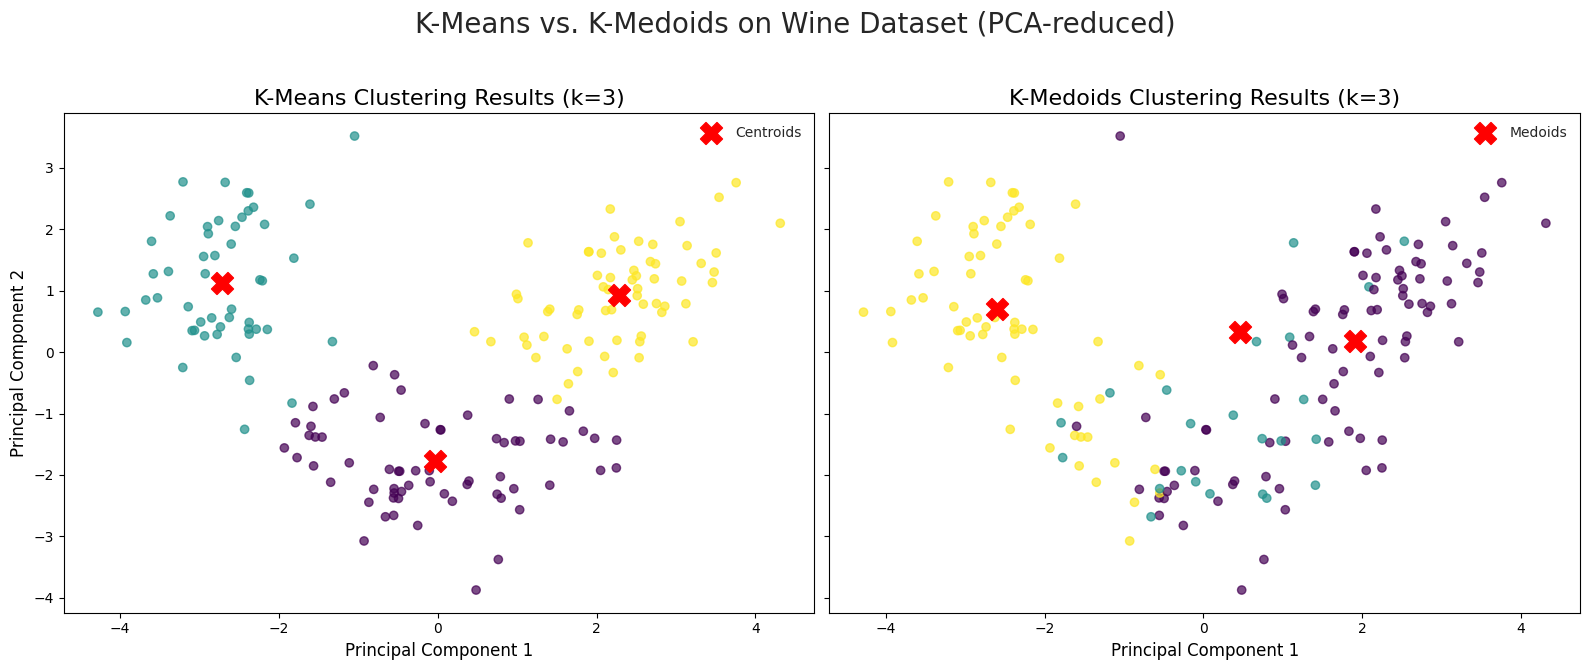


--- Performance Comparison ---
   Algorithm  Silhouette Score  Adjusted Rand Index
0    K-Means            0.2849               0.8975
1  K-Medoids            0.1548               0.3413


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Scikit-learn for dataset, preprocessing, and metrics
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

# --- K-Medoids (PAM) Implementation ---
def kmedoids_pam(X, n_clusters, max_iter=300, random_state=42):
    """
    K-Medoids clustering using the Partitioning Around Medoids (PAM) algorithm.

    Parameters:
    - X: The dataset (numpy array).
    - n_clusters: The number of clusters (k).
    - max_iter: Maximum number of iterations.
    - random_state: Seed for reproducibility.

    Returns:
    - labels: Cluster labels for each data point.
    - medoids: The final medoids (actual data points).
    """
    np.random.seed(random_state)
    
    # 1. Initialization: Randomly select k data points as initial medoids
    num_samples, _ = X.shape
    initial_medoid_indices = np.random.choice(num_samples, n_clusters, replace=False)
    medoids = X[initial_medoid_indices, :]
    
    # Store previous medoids to check for convergence
    old_medoids = np.zeros_like(medoids)
    
    for i in range(max_iter):
        # Check for convergence
        if np.array_equal(old_medoids, medoids):
            break
        old_medoids = np.copy(medoids)

        # 2. Assignment Step: Assign each data point to the nearest medoid
        distances = cdist(X, medoids, 'euclidean')
        labels = np.argmin(distances, axis=1)
        
        # 3. Update Step: For each cluster, find the point that minimizes the sum of distances
        for k in range(n_clusters):
            # Get all points belonging to the current cluster
            cluster_points_indices = np.where(labels == k)[0]
            
            # If a cluster is empty, re-initialize its medoid to a random point
            if len(cluster_points_indices) == 0:
                medoids[k] = X[np.random.choice(num_samples, 1), :]
                continue
            
            cluster_points = X[cluster_points_indices, :]
            
            # Calculate the cost (sum of distances) for each point in the cluster if it were the medoid
            costs = np.sum(cdist(cluster_points, cluster_points, 'euclidean'), axis=1)
            
            # Find the point with the minimum cost
            best_new_medoid_index_in_cluster = np.argmin(costs)
            
            # Update the medoid to the point with the lowest cost
            medoids[k, :] = cluster_points[best_new_medoid_index_in_cluster, :]
            
    return labels, medoids

# --- Main Script ---

# Step 1: Load and Prepare the Data
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Data loading and scaling complete.")

# Step 2: Implement K-Means Clustering
print("\nRunning K-Means...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate K-Means performance metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"K-Means Adjusted Rand Index (ARI): {kmeans_ari:.4f}")

# Step 3: Implement K-Medoids Clustering
print("\nRunning K-Medoids (custom implementation)...")
kmedoids_labels, kmedoids_centers = kmedoids_pam(X_scaled, n_clusters=3, random_state=42)

# Calculate K-Medoids performance metrics
kmedoids_silhouette = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_ari = adjusted_rand_score(y, kmedoids_labels)
print(f"K-Medoids Silhouette Score: {kmedoids_silhouette:.4f}")
print(f"K-Medoids Adjusted Rand Index (ARI): {kmedoids_ari:.4f}")


# Step 4: Visualize and Compare Results
print("\nGenerating plots...")
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get cluster centers and transform them to PCA space
kmeans_centers_pca = pca.transform(kmeans.cluster_centers_)
kmedoids_centers_pca = pca.transform(kmedoids_centers) # Use the medoids from our function

# Create side-by-side scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
plt.style.use('seaborn-v0_8-whitegrid')

# K-Means Plot
ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o', alpha=0.7)
ax1.scatter(kmeans_centers_pca[:, 0], kmeans_centers_pca[:, 1], s=250, c='red', marker='X', label='Centroids')
ax1.set_title('K-Means Clustering Results (k=3)', fontsize=16)
ax1.set_xlabel('Principal Component 1', fontsize=12)
ax1.set_ylabel('Principal Component 2', fontsize=12)
ax1.legend()

# K-Medoids Plot
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=kmedoids_labels, cmap='viridis', marker='o', alpha=0.7)
ax2.scatter(kmedoids_centers_pca[:, 0], kmedoids_centers_pca[:, 1], s=250, c='red', marker='X', label='Medoids')
ax2.set_title('K-Medoids Clustering Results (k=3)', fontsize=16)
ax2.set_xlabel('Principal Component 1', fontsize=12)
ax2.legend()

fig.suptitle('K-Means vs. K-Medoids on Wine Dataset (PCA-reduced)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Performance Comparison Table ---
results_df = pd.DataFrame({
    'Algorithm': ['K-Means', 'K-Medoids'],
    'Silhouette Score': [kmeans_silhouette, kmedoids_silhouette],
    'Adjusted Rand Index': [kmeans_ari, kmedoids_ari]
})
print("\n--- Performance Comparison ---")
print(results_df.round(4))
